In [45]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import os
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

KeyboardInterrupt: 

In [ ]:
import importlib
try: 
    importlib.reload(utils)
    importlib.reload(generators)
    importlib.reload(trainers)
    print("libs reloaded")
except:
    import generators 
    import trainers
    import utils
    print("libs imported")

VAE = generators.VAE
TrainerMaskVAE = trainers.TrainerMaskVAE

libs imported


# Mask VAE

In [ ]:
WORKING_DIR = Path(r"C:\Users\marti\OneDrive - TU Eindhoven\Documenten\Master\Q3\Capita Selecta\Project")
DATA_DIR = WORKING_DIR / "Data"
PROGRESS_DIR_VAE = WORKING_DIR / "progress_vae"
PROGRESS_DIR_VAE.mkdir(parents=True, exist_ok=True)
TENSORBOARD_LOGDIR = "vae_runs"

N = 15
NO_VALIDATION_PATIENTS = 3
train_size = N-NO_VALIDATION_PATIENTS
seed = 0
IMAGE_SIZE = [64,64]

Z_DIM = 2

BATCH_SIZE = 32
N_EPOCHS = 100
DECAY_LR_AFTER = 50
LEARNING_RATE = 1e-3

exp = str(N_EPOCHS) + 'epochs_' + str(Z_DIM) + 'zdim'
EXPERIMENT_DIR = PROGRESS_DIR_VAE / exp
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

OPTIMIZER = lambda parameters, lr : torch.optim.NAdam(parameters, lr=lr, betas=(0.5,0.999))

# loewr epochs increases weights faster
KLD_ANNEALING_EPOCHS = 25

def lambda_lr(the_epoch):
    return (
        1.0
        if the_epoch < DECAY_LR_AFTER
        else 1 - float(the_epoch - DECAY_LR_AFTER) / (N_EPOCHS - DECAY_LR_AFTER)
    )

In [ ]:
utils.remove_empty_masks(DATA_DIR)

In [ ]:
# find patient folders in training directory
# excluding hidden folders (start with .)

patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]

train_indx, valid_indx = train_test_split(patients, random_state=seed, train_size=train_size)

# split in training/validation after shuffling
partition = {
    "train": train_indx,
    "validation": valid_indx,
}
# load training data and create DataLoader with batching and shuffling
train_set = utils.ProstateMRMaskDataset(partition["train"], IMAGE_SIZE)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# load validation data
valid_set = utils.ProstateMRMaskDataset(partition["validation"], IMAGE_SIZE)
valid_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

transform = transforms.Compose([
     transforms.RandomRotation((-6.,+6.), interpolation=transforms.InterpolationMode.NEAREST),
     transforms.RandomResizedCrop((64,64), scale=(0.8,1.), ratio=(1,1), interpolation=transforms.InterpolationMode.NEAREST, antialias=True)
 ])

train_set.transform = transform
    
train_set.labels = train_set.labels[:,0:1]
valid_set.labels = valid_set.labels[:,0:1]

NameError: name 'DATA_DIR' is not defined

In [ ]:
vae_model = VAE(spade=False).to(device)
optimizer = OPTIMIZER(vae_model.parameters(), lr=LEARNING_RATE)
vae_trainer = TrainerMaskVAE(
    vae_model,
    optimizer,
    KLD_ANNEALING_EPOCHS,
    PROGRESS_DIR_VAE,
    train_loader,
    valid_loader,
    EXPERIMENT_DIR,
    device,
)

In [ ]:
vae_trainer.train(N_EPOCHS, lambda_lr=lambda_lr)

  0%|          | 0/22 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Plot reconstruction loss

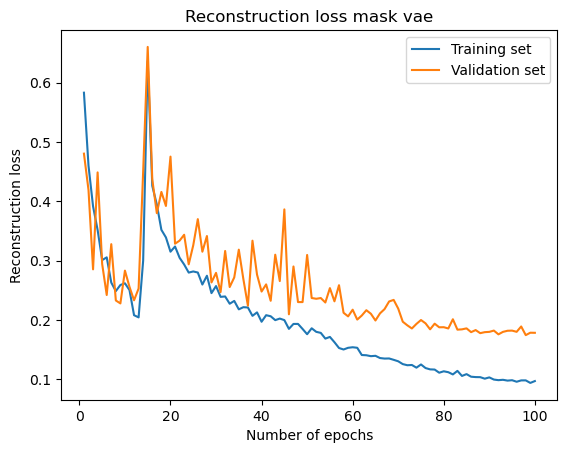

In [ ]:
plt.plot(range(1,N_EPOCHS+1), vae_trainer.train_losses[0])
plt.plot(range(1,N_EPOCHS+1), vae_trainer.valid_losses[0])
plt.xlabel('Number of epochs')
plt.ylabel('Reconstruction loss')
plt.title('Reconstruction loss mask vae')
plt.legend(['Training set', 'Validation set'])
plot_name = 'RECON_LOSS'+str(N_EPOCHS) + 'epochs_' + str(Z_DIM) + '_latentdim.png'
path = EXPERIMENT_DIR / plot_name

plt.savefig(path, dpi=200)

### Plot KLD loss

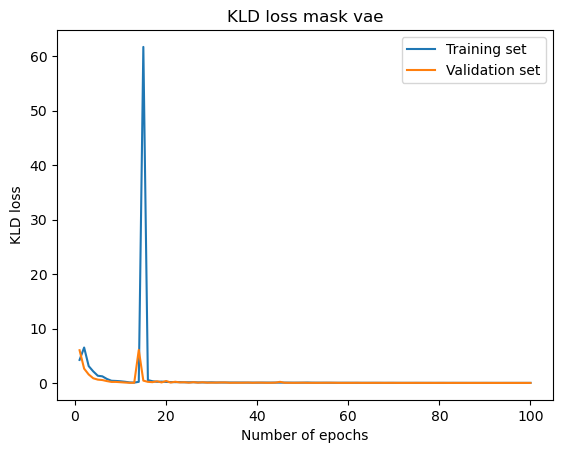

In [ ]:
plt.plot(range(1,N_EPOCHS+1), vae_trainer.train_losses[1])
plt.plot(range(1,N_EPOCHS+1), vae_trainer.valid_losses[1])
plt.ylabel('KLD loss')
plt.xlabel('Number of epochs')
plt.title('KLD loss mask vae')
plt.legend(['Training set', 'Validation set'])
plot_name = 'KLD_LOSS'+str(N_EPOCHS) + 'epochs_' + str(Z_DIM) + '_latentdim.png'
path = EXPERIMENT_DIR / plot_name

plt.savefig(path, dpi=200)

### Plot losses together (sum)

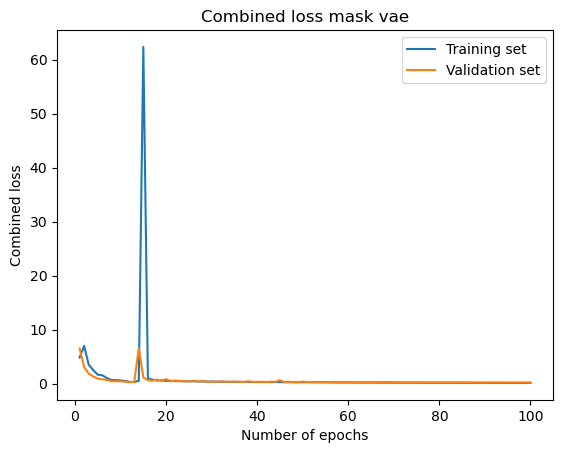

In [ ]:
plt.plot(range(1,N_EPOCHS+1), [sum(x) for x in zip(*vae_trainer.train_losses)])
plt.plot(range(1,N_EPOCHS+1), [sum(x) for x in zip(*vae_trainer.valid_losses)])
plt.ylabel('Combined loss')
plt.xlabel('Number of epochs')
plt.title('Combined loss mask vae')
plt.legend(['Training set', 'Validation set'])
plot_name = 'COMBINED_LOSS'+str(N_EPOCHS) + 'epochs_' + str(Z_DIM) + '_latentdim.png'
path = EXPERIMENT_DIR / plot_name

plt.savefig(path, dpi=200)

### Save losses in .txt files

In [ ]:
TRAIN_DIR = EXPERIMENT_DIR / 'training'
VALID_DIR = EXPERIMENT_DIR / 'validation'
TRAIN_DIR.mkdir(parents=True, exist_ok=True)
VALID_DIR.mkdir(parents=True, exist_ok=True)

filename = str(N_EPOCHS) + 'epochs_' + str(Z_DIM) + '_latentdim.txt' 

file_train = open(TRAIN_DIR / filename, 'w')
file_valid = open(VALID_DIR / filename,'w')

for i, j in zip(vae_trainer.train_losses, vae_trainer.valid_losses):
    file_train.write("{loss}\n".format(loss=i))
    file_valid.write("{loss}\n".format(loss=j))

file_train.close()
file_valid.close()
